In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from sympy import sympify
import cv2
import matplotlib.pyplot as plt
import joblib

In [2]:
data_dir = "data"
img_size = 45

# Collect labels
symbol_labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Label mappings
symbol_to_index = {label: idx for idx, label in enumerate(symbol_labels)}
index_to_label = {v: k for k, v in symbol_to_index.items()}

X_symbols, y_symbols = [], []

# Load dataset images
for label in symbol_labels:
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            try:
                img_path = os.path.join(folder_path, file)
                img = load_img(img_path, color_mode="grayscale", target_size=(img_size, img_size))
                img = img_to_array(img) / 255.0
                X_symbols.append(img)
                y_symbols.append(symbol_to_index[label])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Convert to numpy arrays
X_all = np.array(X_symbols)
y_all = np.array(y_symbols)

print("Dataset loaded:", X_all.shape, y_all.shape)
print("Classes:", index_to_label)


Dataset loaded: (200559, 45, 45, 1) (200559,)
Classes: {0: '!', 1: '(', 2: ')', 3: '+', 4: ',', 5: '-', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: '[', 17: ']', 18: 'div', 19: 'sqrt', 20: 'times', 21: '{', 22: '}'}


In [3]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        img = img.squeeze()  # 45x45
        hog_feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(4,4),
            cells_per_block=(2,2),
            block_norm="L2-Hys"
        )
        features.append(hog_feat)
    return np.array(features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print("HOG feature shape (per image):", X_train_hog.shape[1])

HOG feature shape (per image): 3600


In [4]:
rf_hog = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    min_samples_split=2,
    max_depth=None
)

rf_hog.fit(X_train_hog, y_train)

# Evaluate
y_pred_hog = rf_hog.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test, y_pred_hog))
print("\nClassification report:\n",
      classification_report(y_test, y_pred_hog,
                            target_names=[index_to_label[i] for i in sorted(index_to_label)]))

Accuracy: 0.9977812126047069

Classification report:
               precision    recall  f1-score   support

           !       1.00      1.00      1.00       273
           (       1.00      1.00      1.00      2840
           )       1.00      1.00      1.00      2778
           +       1.00      1.00      1.00      5111
           ,       0.99      0.93      0.96       337
           -       1.00      1.00      1.00      6775
           0       1.00      1.00      1.00      1425
           1       0.99      1.00      1.00      5286
           2       1.00      1.00      1.00      5136
           3       1.00      1.00      1.00      2243
           4       1.00      1.00      1.00      1437
           5       1.00      0.99      0.99       774
           6       1.00      1.00      1.00       633
           7       1.00      0.98      0.99       589
           8       1.00      1.00      1.00       643
           9       1.00      0.99      1.00       776
           [       1.00    

In [5]:
joblib.dump(rf_hog, "models/rf_hog.pkl")

['models/rf_hog.pkl']

In [6]:
joblib.dump(index_to_label, "models/index_to_label.pkl")

['models/index_to_label.pkl']

In [7]:
rf_hog = joblib.load("models/rf_hog.pkl")

y_pred = rf_hog.predict(X_test_hog)
print("Loaded model accuracy:", accuracy_score(y_test, y_pred))

Loaded model accuracy: 0.9977812126047069


In [8]:
def solve_expression(expr):
    # Safely evaluate a math expression string. Uses sympy to avoid Python's eval() risks.
    try:
        result = sympify(expr).evalf()  # sympy safely parses the math expression
        return result
    except Exception as e:
        return f"Error solving expression: {e}"


In [9]:
def segment_expression(img_path, img_size=45, show_steps=False):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Threshold (invert so text is white)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    symbol_imgs = []
    bounding_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Skip very small contours
        if w < 5 or h < 5:
            continue

        roi = thresh[y:y+h, x:x+w]

        # Add padding to make square
        side = max(w, h)
        square = np.zeros((side, side), dtype=np.uint8)
        square[(side-h)//2:(side-h)//2+h, (side-w)//2:(side-w)//2+w] = roi

        # Resize to 45x45
        roi_resized = cv2.resize(square, (img_size, img_size), interpolation=cv2.INTER_AREA)

        # Normalize
        roi_resized = roi_resized.astype("float32") / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=-1)

        symbol_imgs.append(roi_resized)
        bounding_boxes.append((x, y, w, h))

    # Sort symbols left-to-right
    sorted_symbols = [s for _, s in sorted(zip(bounding_boxes, symbol_imgs), key=lambda b: b[0][0])]

    if show_steps:
        plt.imshow(thresh, cmap="gray")
        plt.title("Thresholded image")
        plt.show()

        for i, s in enumerate(sorted_symbols):
            plt.subplot(1, len(sorted_symbols), i+1)
            plt.imshow(s.squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()

    return sorted_symbols


In [10]:
def classify_expression(img_path):
    symbols = segment_expression(img_path, img_size=45, show_steps=True)
    predicted_chars = [predict_symbol_rf_hog(s) for s in symbols]
    return "".join(predicted_chars)

def solve_expression(expr):
    try:
        return sympify(expr).evalf()
    except Exception as e:
        return f"Error: {e}"

In [11]:
# Predicting with hog instead of just RF
def predict_symbol_rf_hog(img):
    img = img.squeeze()
    hog_feat = hog(
        img,
        orientations=9,
        pixels_per_cell=(4, 4),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    ).reshape(1, -1)

    pred_idx = rf_hog.predict(hog_feat)[0]
    return index_to_label[pred_idx]

In [12]:
# Sanity check
test_symbol = segment_expression("test_images/math_img.png", img_size=45)[0]
print("Segment shape:", test_symbol.shape)

from skimage.feature import hog
feat = hog(test_symbol.squeeze(),
           orientations=9,
           pixels_per_cell=(4,4),
           cells_per_block=(2,2),
           block_norm="L2-Hys").reshape(1,-1)
print("HOG length:", feat.shape[1])

Segment shape: (45, 45, 1)
HOG length: 3600


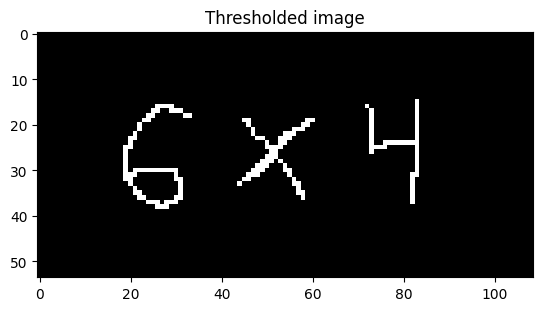

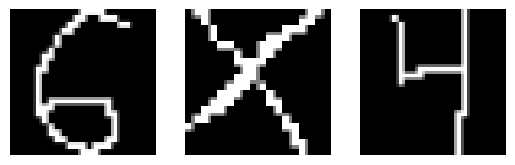

Recognized expression: 6times4
Result: 24.0000000000000


In [13]:
def solving(expr_str):
    expr_str = expr_str.replace("times", "*")
    expr_str = expr_str.replace("div", "/")
    expr_str = expr_str.replace("sqrt", "**0.5")

    try:
        expr = sympify(expr_str)
        return expr.evalf()
    except Exception as e:
        return f"Error: {e}"

# Example: feed an image
expr_img = "test_images/math_img.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solving(expr_str)
print("Result:", result)
